In [24]:
## TP2 Big Data ##

## Parte I ##
#Importamos libreria
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Importamos los datos
data = pd.read_csv("C:/Users/tomas/Documents/UdeSA/Cuarto Año/Primer Cuatri/Big Data/TP2/Base Airbnb NY.csv")

In [25]:
# 1) a) Sacamos los datos duplicados (por id)
data.drop_duplicates(subset='id', inplace=True)

In [26]:
# 1) b) Sacamos columnas que no agreguen informacion
data.drop(columns=['name', 'host_name'], inplace=True)

In [27]:
# 1) c) Nos fijamos los missing values de cada columna
missing_values = data.isna().sum()
print(missing_values)

data['reviews_per_month'].fillna(0, inplace=True)

id                                    0
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                15
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


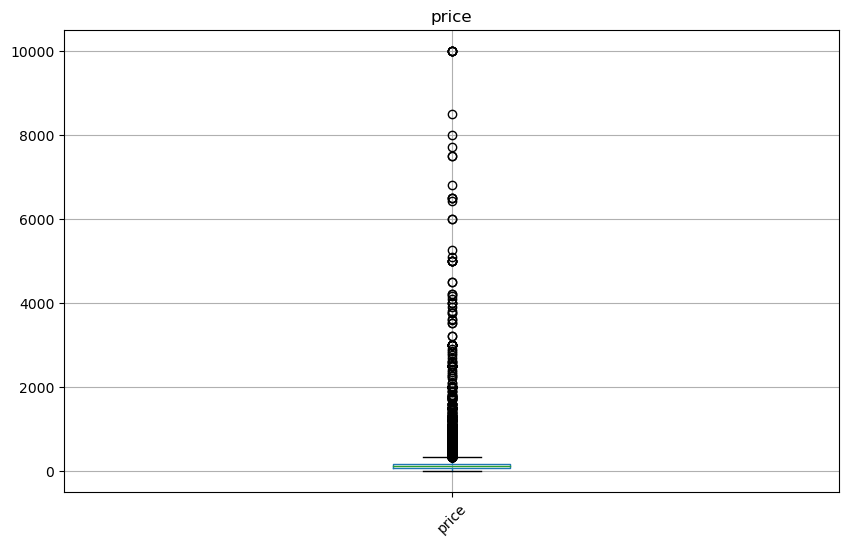

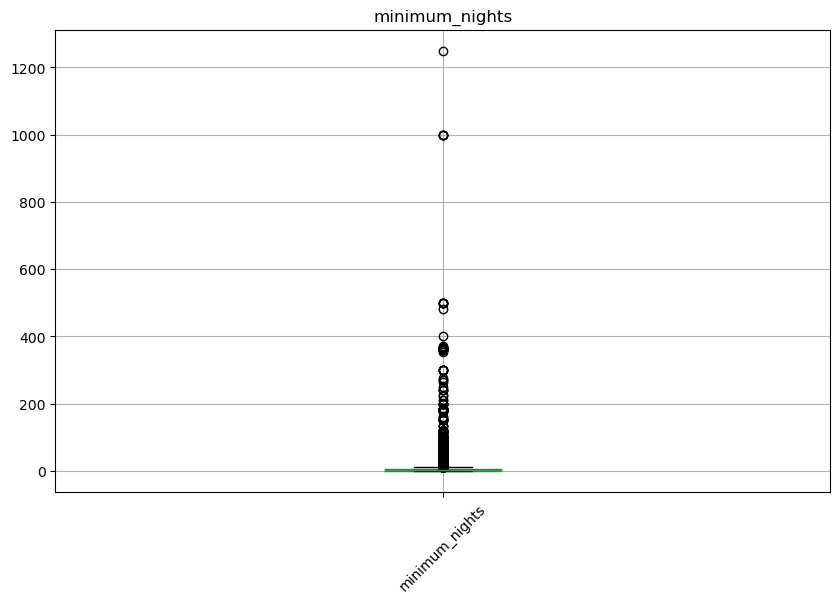

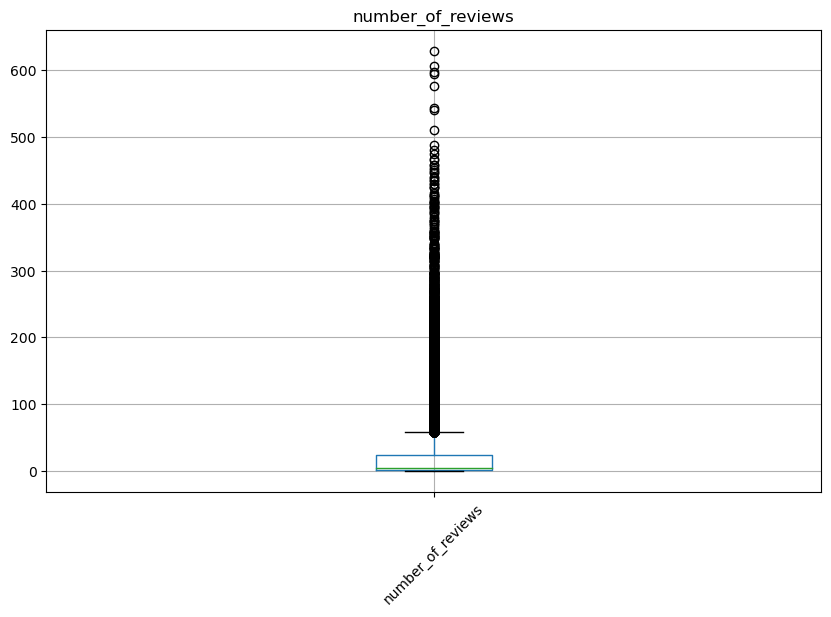

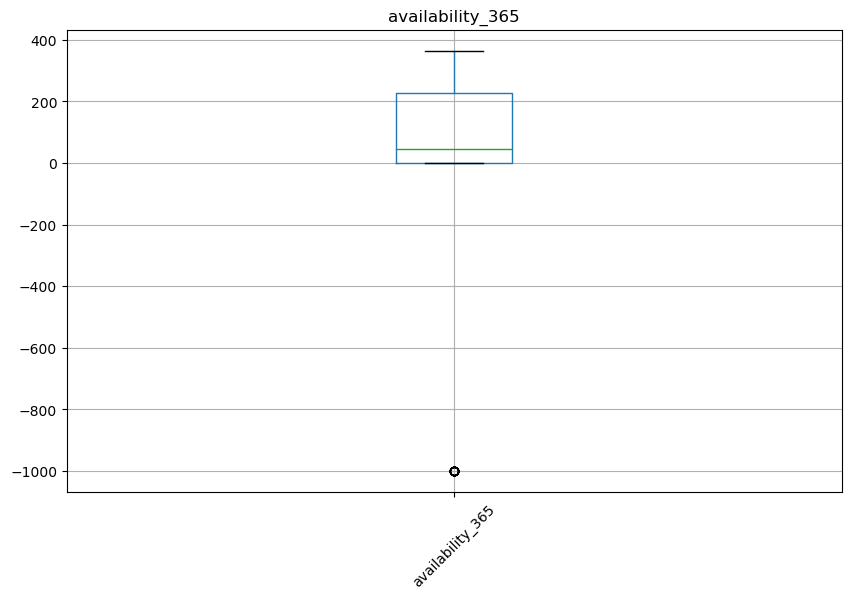

In [28]:
# 1) d) Graficamos datos numericos para encontrar outliers 

columnas_numericas = ['price', 'minimum_nights' , 'number_of_reviews', 'availability_365']

for i in range(0, len(columnas_numericas)):   
    plt.figure(figsize = (10, 6))
    data.boxplot(column = columnas_numericas[i])
    plt.title(columnas_numericas[i])
    plt.xticks(rotation = 45)
    plt.show()

#Eliminamos columnas con precio = 0

data = data[data['price'] != 0]

#Eliminamos columnas con minimum_nights >= 900

data = data[data['minimum_nights'] < 900]

#Filtramos por availability_365 positiva

data = data[data['availability_365'] > 0]

In [29]:
# 1) e) Transformar neighborhood_group y room_type a numericas

# Creamos dummies para cada neighborhood distinto 
dummy_cols = pd.get_dummies(data['neighbourhood_group'], prefix='neighbourhood_').astype(int)

# Concatenar las variables dummy al DataFrame original
data = pd.concat([data, dummy_cols], axis=1)

#Repetimos proceso para room_type

# Creamos dummies para cada tipo de cuarto distinto 
dummy_cols_room = pd.get_dummies(data['room_type'], prefix='room_type_').astype(int)

# Concatenar las variables dummy al DataFrame original
data = pd.concat([data, dummy_cols_room], axis=1)

In [30]:
# 1) f) Cantidad de ofertas por zona

#Agrupamos por barrio y contamos observaciones
group_counts = data.groupby('neighbourhood_group').size()

#Guardamos informacion en offer_group
offer_group = pd.DataFrame({'neighbourhood_group': group_counts.index, 'offer_group': group_counts.values})
print(offer_group)

#Juntamos ambos datasets 
data = pd.merge(data, offer_group, on='neighbourhood_group', how='left')

  neighbourhood_group  offer_group
0               Bronx          912
1            Brooklyn        12248
2           Manhattan        13554
3              Queens         4294
4       Staten Island          331


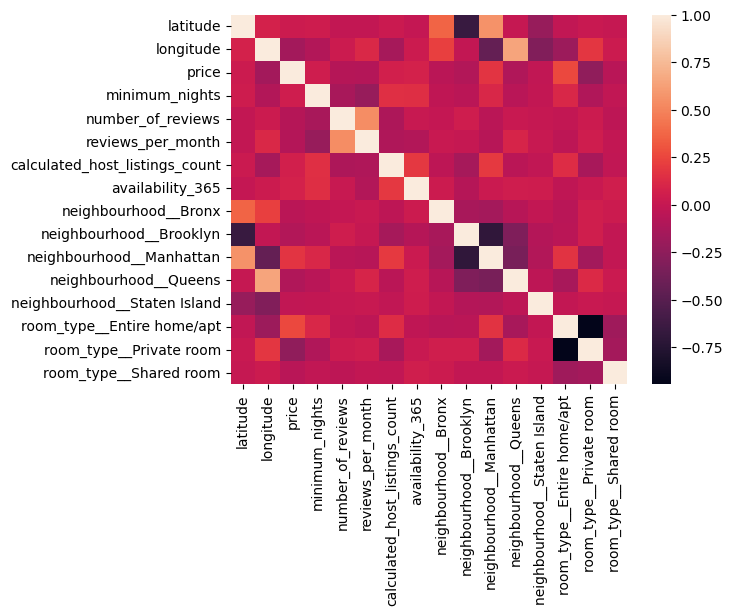

In [31]:
## Parte II ##

# 1) Correlograma

#Nos quedamos con las variables de interes 

#Eliminamos neighbourhood_group y room_type
data_corr = data.drop(columns=['neighbourhood_group', 'room_type'])

columns_to_keep = ['latitude', 'longitude', 'price', 'minimum_nights', 
                   'number_of_reviews', 'reviews_per_month', 
                   'calculated_host_listings_count', 'availability_365']

#Inclumos las dummies
dummies_neighbourhood = [col for col in data.columns if col.startswith('neighbourhood_')]
dummies_room_type = [col for col in data.columns if col.startswith('room_type_')]

#Juntamos lista de columnas a utilizar
columns_corr = columns_to_keep + dummies_neighbourhood + dummies_room_type

data_corr = data[columns_corr].drop(columns=['neighbourhood_group'])

#Computamos las correlaciones y graficamos
correlaciones = sns.heatmap(data_corr.corr())

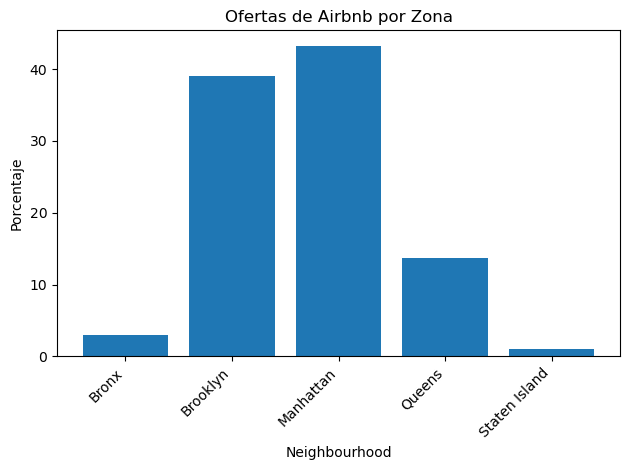

In [32]:
# 2) Cantidad de oferentes por categoria

group_counts = group_counts.to_frame().reset_index()
cols = group_counts.columns

group_counts.rename(columns={'neighbourhood_group': 'neighbourhood', cols[1]: 'count'}, inplace=True)

#Cambiamos valores a porcentajes
suma = group_counts['count'].sum()

group_counts['percent'] = (group_counts['count']/suma)*100

plt.bar(group_counts['neighbourhood'], group_counts['percent'])
plt.xlabel('Neighbourhood')
plt.ylabel('Porcentaje')
plt.title('Ofertas de Airbnb por Zona')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

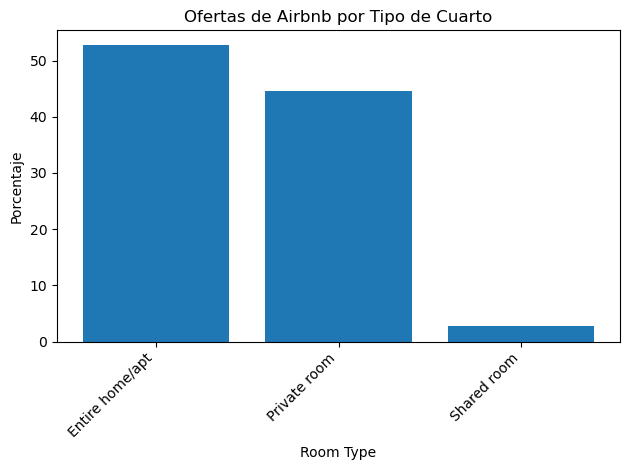

In [33]:
#Repetimos para tipo de cuarto. Primero creamos el dataset con el count por tipo de cuarto

#Agrupamos por room type y contamos observaciones
group_room = data.groupby('room_type').size()

group_room = group_room.to_frame().reset_index()

cols_room = group_room.columns

group_room.rename(columns={cols_room[1]: 'count'}, inplace=True)

#Cambiamos valores a porcentajes
suma_room = group_room['count'].sum()

group_room['percent'] = (group_room['count']/suma_room)*100

plt.bar(group_room['room_type'], group_room['percent'])
plt.xlabel('Room Type')
plt.ylabel('Porcentaje')
plt.title('Ofertas de Airbnb por Tipo de Cuarto')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

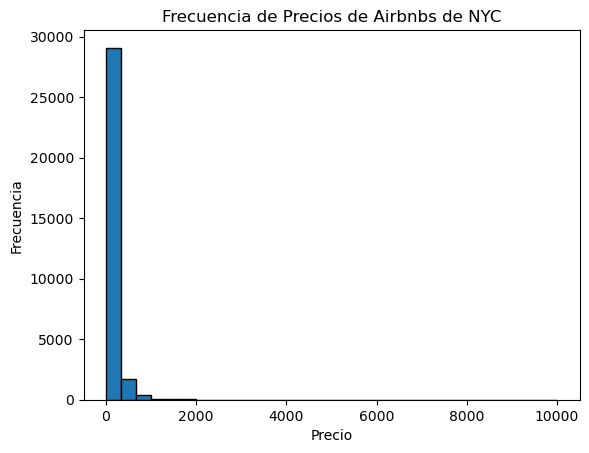

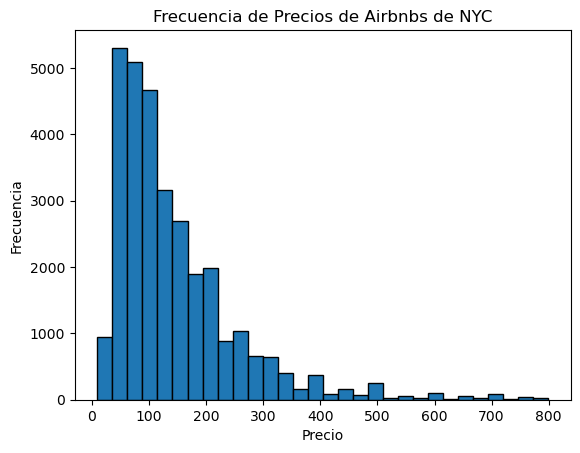

In [34]:
# 3) Histograma de precios

plt.hist(data['price'], bins=30, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Precios de Airbnbs de NYC')
plt.show()

#Histograma con precio < 800
pr = data[data['price'] < 800]

plt.hist(pr['price'], bins=30, edgecolor='black')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Precios de Airbnbs de NYC')
plt.show()

In [35]:
#Buscamos el minimo, maximo y promedio del precio
precio_min = data['price'].min()
precio_max = data['price'].max()
precio_medio = data['price'].mean()

print("Precio minimo:", precio_min)
print("Precio maximo:", precio_max)
print("Precio medio:", precio_medio)

Precio minimo: 10.0
Precio maximo: 10000.0
Precio medio: 162.13637669592975


In [36]:
#Promedio de precio por barrio y por tipo de cuarto
precio_barrio = data.groupby('neighbourhood_group')['price'].mean()
precio_cuarto = data.groupby('room_type')['price'].mean()

print("Precio promedio por", precio_barrio)
print("Precio promedio por", precio_cuarto)

Precio promedio por neighbourhood_group
Bronx             89.025275
Brooklyn         132.968633
Manhattan        214.225240
Queens           100.080382
Staten Island    114.229607
Name: price, dtype: float64
Precio promedio por room_type
Entire home/apt    224.646753
Private room        93.998781
Shared room         66.095238
Name: price, dtype: float64


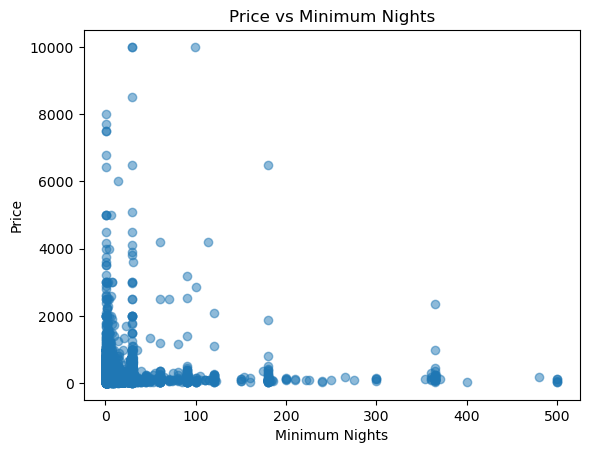

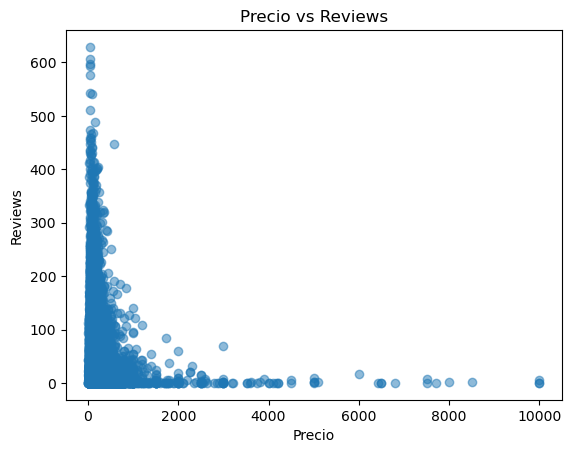

In [37]:
# 4) Scatterplots 

# price vs minnimun_nights
plt.scatter(data['minimum_nights'], data['price'], alpha=0.5)
plt.xlabel('Minimum Nights')
plt.ylabel('Price')
plt.title('Price vs Minimum Nights')
plt.show()

# precio vs reviews
plt.scatter(data['price'], data['number_of_reviews'], alpha = 0.5)
plt.xlabel('Precio')
plt.ylabel('Reviews')
plt.title('Precio vs Reviews')
plt.show()

Varianza explicada: [0.16561636 0.13893663]
Loadings:
 [[-0.01898302  0.27211193 -0.35083422  0.18227041 -0.12300329 -0.16209127
   0.2335351   0.04111891 -0.02803575 -0.31392558  0.49746617 -0.26007968
   0.01534496  0.36018304 -0.35633195 -0.0163016 ]
 [-0.16419054 -0.49912942 -0.30799484  0.03924842  0.01483358 -0.06439396
  -0.00956369 -0.0675445  -0.25618236  0.49532538 -0.22239139 -0.30138487
   0.1502905   0.2735754  -0.26076306 -0.04235767]]
Loadings del CP1:
 [-0.01898302  0.27211193 -0.35083422  0.18227041 -0.12300329 -0.16209127
  0.2335351   0.04111891 -0.02803575 -0.31392558  0.49746617 -0.26007968
  0.01534496  0.36018304 -0.35633195 -0.0163016 ]

Loading Vector CP1:
host_id: -0.019
latitude: 0.272
longitude: -0.351
minimum_nights: 0.182
number_of_reviews: -0.123
reviews_per_month: -0.162
calculated_host_listings_count: 0.234
availability_365: 0.041
neighbourhood__Bronx: -0.028
neighbourhood__Brooklyn: -0.314
neighbourhood__Manhattan: 0.497
neighbourhood__Queens: -0.26
ne

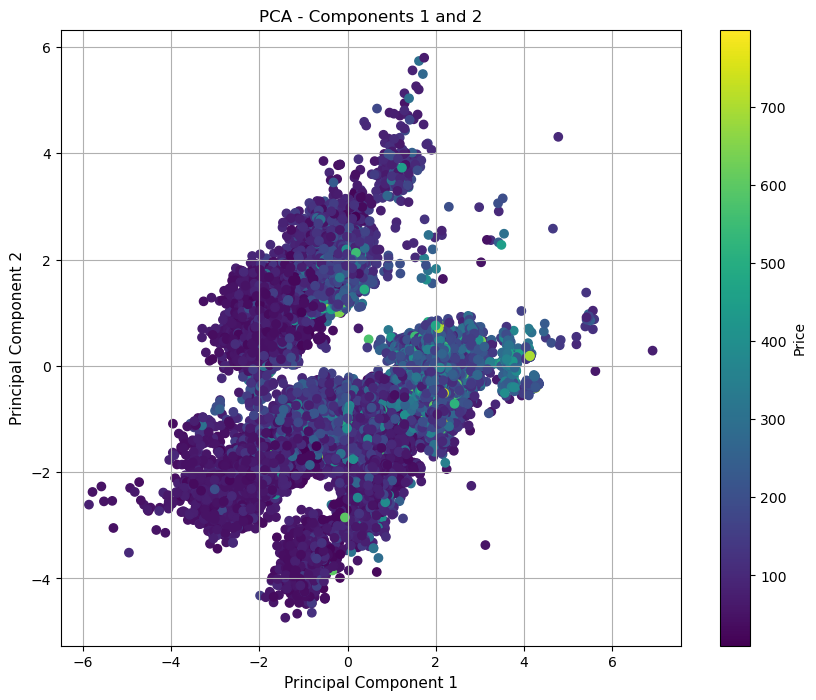

In [38]:
# 5) PCA 
#Separamos variables 
X = pr.drop(columns = ['neighbourhood_group', 'room_type', 'neighbourhood',
                       'id', 'last_review', 'offer_group', 'price'])

y = pr['price']

#Estandarizamos las variables
sc = StandardScaler()
X_stand = sc.fit_transform(X)

#Aplicamos PCA con 2 componentes
pca = PCA(n_components = 2)

dpto_pca = pca.fit_transform(X_stand) 

#Varianza explicada y loading vectors
print("Varianza explicada:", pca.explained_variance_ratio_)

loading_vectors = pca.components_ 
print("Loadings:\n", pca.components_)
print("Loadings del CP1:\n",pca.components_[0]) 

for i, loading_vector in enumerate(loading_vectors):
    print(f"\nLoading Vector CP{i+1}:")
    for j, feature in enumerate(X.columns[:-1]):
        print(f"{feature}: {round(loading_vector[j],3)}")
    print()

pca_df = pd.DataFrame(data=dpto_pca, columns=['Componente_1', 'Componente_2'])

# Añadir la variable objetivo al DataFrame de los componentes principales
pca_df['precio'] = y

#Graficar PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['Componente_1'], pca_df['Componente_2'], c=pr['price'], cmap='viridis')
plt.xlabel('Principal Component 1', fontsize=11)
plt.ylabel('Principal Component 2', fontsize=11)
plt.title('PCA - Components 1 and 2')
plt.colorbar(label='Price')
plt.grid(True) 
plt.show()

In [20]:
## Parte III ##

data_corr.dropna(inplace = True)

# 1) Separacion de datos por variable
y = data_corr['price']
X = data_corr.drop(columns = ['price'])

In [21]:
# 2) Division de datos en test/train 
X['intercept'] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

In [22]:
# 3) Regresion Lineal con train dataset
model = LinearRegression()

model.fit(X_train, y_train)

# Hacemos la prediccion
y_pred = model.predict(X_test)

# Calculamos los errores
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print("Error de pronostico promedio =", rmse)

Error de pronostico promedio = 223.30292718539837


In [ ]:
#Graficamos los precios reales vs los predichos
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Valores reales vs. predichos')
#plt.xlim(0, 800)
#plt.ylim(0,800)
plt.show()

In [ ]:
#Calculamos residuos
residuals = y_test - y_pred

#Definimos los bins
bin_edges = np.arange(0, 10001, 50)  

#Calcular los índices de los bins para cada precio real
bin_indices = np.digitize(y_test, bin_edges)

#Calcular el residuo promedio por bin de precio real
residuals_mean_by_bin = [residuals[bin_indices == i].mean() for i in range(1, len(bin_edges))]

#Graficamos
plt.bar(bin_edges[:-1], residuals_mean_by_bin, width=50, align='edge')
plt.xlabel('Precio real')
plt.ylabel('Residuo promedio')
plt.title('Residuo promedio por bin de precio real')
plt.show()